# Piece-Wise Fitting of Pulsation Ratio Using a Parabola and a Line
As the title says, replace PR using a parabola fit for near detectors and a linear fit for far-away detectors. We are fitting PR vs. SDD. This is based on the trends seen from plotting the true simulation data. The core observation here is that, with all other TMPs fixed, increasing depth shifts the peak of the parabola farther away but the tail always has the exact same shape/eqn. No shifts what so ever. 

In [12]:
# Load in pre-saved data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json
from inverse_modelling_tfo.features.build_features import TwoColumnOperationFeatureBuilder

# Load the log intensity data
# pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "pulsation_ratio.pkl"
# pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "pulsation_ratio_interp.pkl"
data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2.pkl"
# pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2_interp.pkl"
data = pd.read_pickle(data_path)
data_config_path = data_path.with_suffix('.json')
with open(data_config_path, 'r') as file:
    data_config = json.load(file)
feature_columns = data_config['features']
labels = data_config['labels']

# Create PR
# ## Create I2/I1 data
# # Get I2/I1 column names
i1_wv2 = feature_columns[:len(feature_columns)//4]
i1_wv1 = feature_columns[len(feature_columns)//4:2*len(feature_columns)//4]
i2_wv2 = feature_columns[2*len(feature_columns)//4:3*len(feature_columns)//4]
i2_wv1 = feature_columns[3*len(feature_columns)//4:]


# Filter Data
all_depths = data['Maternal Wall Thickness'].unique()
all_depths.sort()
chosen_depth = all_depths[0]
data = data[data['Maternal Wall Thickness'] == chosen_depth]

# Create the feature builders
fb1 = TwoColumnOperationFeatureBuilder(i1_wv1, i2_wv1, '/', False, feature_columns, labels)
fb2 = TwoColumnOperationFeatureBuilder.from_chain(fb1, i1_wv2, i2_wv2, '/', False)

# Transform the data
data = fb2(data)

pr_features = fb2.get_feature_names()

In [13]:
wv1_columns = [col for col in data.columns if '_1.0_' in col]
wv2_columns = [col for col in data.columns if '_2.0_' in col]
sdd = [int(str(col).split('_')[0]) for col in wv1_columns]
sdd = np.array(sdd)
print(sdd)

[10 15 19 24 28 33 37 41 46 50 55 59 64 68 72 77 81 86 90 94]


In [14]:
peak_index = 6  
fitting_x = np.array([sdd] * len(data))
fitting_y = data[wv1_columns].to_numpy()
print(fitting_x.shape)
print(fitting_y.shape)

(16632, 20)
(16632, 20)


In [15]:
# from numpy import polyfit, polyval

# # coeffs = polyfit(np.log(fitting_x.flatten()), np.log(fitting_y.flatten() - 1), 1)
# head_coeffs = polyfit(np.log(fitting_x[0, :peak_index]), np.log(fitting_y[0, :peak_index] - 1), 1)
# tail_coeffs = polyfit(fitting_x[0, peak_index - 1:], fitting_y[0, peak_index - 1:], 1)
# print(head_coeffs)
# print(tail_coeffs)

# # Plots
# fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
# plt.sca(axes[0])
# fitted_y_head = np.exp(polyval(head_coeffs, np.log(sdd[:peak_index]))) + 1
# fitted_y_tail = polyval(tail_coeffs, sdd[peak_index - 1:])
# fitted_y = np.concatenate([fitted_y_head[:-1], fitted_y_tail])
# plt.plot(sdd, fitted_y, label='fit')
# plt.sca(axes[1])
# wv1_columns = [col for col in data.columns if '_1.0_' in col]
# for i in range(100):
#     wv1_data = data[wv1_columns].iloc[i,:].to_numpy()
#     plt.plot(sdd, wv1_data, label=f'row{i}')
# # plt.tight_layout()


In [16]:
# # Plot the derivative
# # make two subplots
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# derivative_zero_crossing = []

# plt.sca(axes[0])
# for i in range(100):
#     wv1_data = data[wv1_columns].iloc[i,:].to_numpy()
#     wv1_data_derivative = np.gradient(wv1_data, sdd)
#     zero_crossing_sdd = np.where(np.sign(wv1_data_derivative[:-1]) != np.sign(wv1_data_derivative[1:]))[0] + 1
#     # zero_crossing_sdd = sdd[zero_crossing_sdd[0]]
#     derivative_zero_crossing.append(zero_crossing_sdd[0])
#     plt.plot(sdd, wv1_data_derivative, label=f'row{i}')

# plt.sca(axes[1])
# plt.plot(derivative_zero_crossing)


In [17]:
# from typing import Optional, Tuple

# def find_break_indices(pr_data: np.ndarray, shallow_depth_left_indice: Optional[int] = None, derivative_threhold: float = 1e-4) -> Tuple[int, int]:
#     """
#     Given a 1D PR data, finds the left and right break indices for our interpolation. The left break index is the final 
#     positive gradient index before the first zero crossing. While at the right index, the gradient is already negative!
#     :param pr_data: The 1D PR data for a given wavelength
#     :param shallow_depth_left_indice: The left index of the shallowest depth model. We assume, this should have the smallest
#     left break index. Sometimes, low index values can be negative. This prevents the finder from picking up those close
#     break index points. We just assume that should be close to 0(or 0).
#     """
#     pr_data_derivative = np.gradient(pr_data)
#     pr_data_derivative[np.abs(pr_data_derivative) < derivative_threhold] = 0.0
#     # Find the zero crossing
#     sign_matrix = np.sign(pr_data_derivative)
#     if shallow_depth_left_indice is not None:
#         sign_matrix[:shallow_depth_left_indice + 1] = +1
#     left_break_index = np.where(sign_matrix[:-1]*sign_matrix[1:] == -1)[0]
#     right_break_index = left_break_index + 1
#     return left_break_index[0], right_break_index[0]


In [18]:
# from numpy import polyfit, polyval
# from typing import Tuple

# def pr_interpolation(pr_data: np.ndarray, sdd: np.ndarray, left_break_index: int, right_break_index: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
#     ## Split Data
#     sdd_left = sdd[:left_break_index + 1]
#     pr_data_left = pr_data[:left_break_index + 1]
#     sdd_right = sdd[right_break_index:]
#     pr_data_right = pr_data[right_break_index:]

#     ## Data Cleanup
#     # Drop data points from the left if they are less than or equal to 1 -> messes up the log
#     sdd_left = sdd_left[pr_data_left > 1]
#     pr_data_left = pr_data_left[pr_data_left > 1]


#     ## Fit the data
#     head_coeffs = polyfit(np.log(sdd_left), np.log(pr_data_left - 1), 1)
#     if len(sdd_right) > 1:
#         tail_coeffs = polyfit(sdd_right, pr_data_right, 1)

#     ## Data Interpolation - on all points not just the given for fitting
#     if len(sdd_right) > 1:
#         fitted_y_head = np.exp(polyval(head_coeffs, np.log(sdd[:left_break_index]))) + 1
#         fitted_y_tail = polyval(tail_coeffs, sdd[left_break_index :])
#         fitted_y = np.concatenate([fitted_y_head, fitted_y_tail])
#     else:
#         fitted_y = np.exp(polyval(head_coeffs, np.log(sdd))) + 1
#     return fitted_y, head_coeffs, tail_coeffs

In [19]:
# ## Plot True vs. Interpolated
# # make two subplots
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
# break_indices = []


# sdd = np.array(sdd)
# for i in range(100):
#     pr_data = data[wv1_columns].iloc[i,:].to_numpy()
#     left_break_index, right_break_index = find_break_indices(pr_data, 2)
#     break_indices.append(left_break_index)
#     fitted_y, head_coeffs, tail_coeffs = pr_interpolation(pr_data, sdd, left_break_index, right_break_index)
#     plt.sca(axes[0])
#     plt.plot(sdd, pr_data, label=f'row{i}')
#     plt.sca(axes[1])
#     plt.plot(sdd, fitted_y, label=f'row{i}')

# print(break_indices)
# plt.tight_layout()

# Alternate Approach
Recreate from stable derivative

In [20]:
from typing import Optional


def create_stable_derivative(pr_data: np.ndarray, derivative_threhold: float = 1e-4, ma_filter_len: int = 3, x_axis: Optional[np.ndarray] = None ) -> np.ndarray:
    if x_axis is None:
        x_axis = np.arange(len(pr_data))
  
    
    pr_data_derivative = np.gradient(pr_data, x_axis)
    pr_data_derivative[np.abs(pr_data_derivative) < derivative_threhold] = 0.0
    # Apply a moving average filter
    pr_data_derivative = np.convolve(pr_data_derivative, np.ones(ma_filter_len)/ma_filter_len, mode='same')

    # Find first negative gradient
    sign_matrix = np.sign(pr_data_derivative)
    left_break_index = np.where(sign_matrix == -1)[0][0]
    negative_derivative = pr_data_derivative[left_break_index]
    pr_data_derivative[left_break_index:] = negative_derivative
    return pr_data_derivative

def recreate_from_derivative(start_value: float, derivatives: np.ndarray, x_axis: Optional[np.ndarray] = None) -> np.ndarray:
    if x_axis is None:
        # If x_axis is not provided, assume uniform spacing
        x_axis = [1] * (len(derivatives) - 1)
    else:
        # Adjust x_axis to match the length of the derivatives array
        x_axis = np.diff(x_axis)
    
    # Recreate the original data by cumulatively summing the derivatives
    # Start with the initial value and add the cumulative sum of the derivatives
    original_data = np.concatenate(([start_value], start_value + np.cumsum(derivatives[:-1] * x_axis)))
    
    return original_data
    

In [21]:
x_axis = sdd
x_axis = np.diff(x_axis)
print(len(x_axis))

19


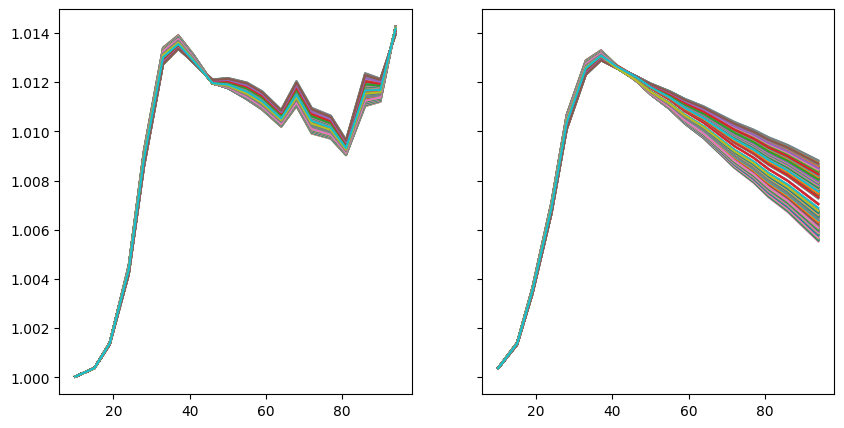

In [22]:
from inverse_modelling_tfo.data_pipelines import interpolate_pr

## Compare true data vs. interpolated data
# make two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(300):
    # pr_data = data[wv1_columns].iloc[i,:].to_numpy()      # fitting I1/I2
    pr_data = data[wv2_columns].iloc[i,:].to_numpy()
    fitted_y = interpolate_pr(pr_data, derivative_threhold=1e-4, ma_filter_len=3)
    plt.sca(axes[0])
    plt.plot(sdd, pr_data, label=f'row{i}')
    plt.sca(axes[1])
    plt.plot(sdd, fitted_y, label=f'row{i}')